In [13]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile
from IPython.display import Audio
from scipy import signal

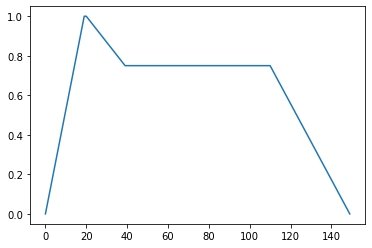

In [7]:
# ADSREXAMPLE
# This script creates a linear ADSR amplitude envelope.
#
# See also ADSR

# Number of samples per fade
a = 20
d = 20
s = 70
r = 40

sustainAmplitude = 0.75

# create each segment A, D, S, R
aFade = np.linspace(0, 1, a)
dFade = np.linspace(1, sustainAmplitude, d)
sFade = sustainAmplitude * np.ones(s)
rFade = np.linspace(sustainAmplitude, 0, r)

# Concatenates total ADSR envelope
env = np.append(aFade, dFade)
env = np.append(env, sFade)
env = np.append(env, rFade)

plt.plot(env)
plt.show()

In [6]:
# ADSR
# This function can be used to apply an ADSR envelope on to an input signal.
#
# Input Variables
#   attackTime: length of attack ramp in milliseconds
#   decayTime: length of decay ramp in milliseconds
#   sustainAmplitude: linear amplitude of sustain segment
#   releaseTime: length of release ramp in ms

def adsr(x, Fs, attackTime, decayTime, sustainAmplitude, releaseTime):
    # Convert time inputs to seconds
    attackTimeSec = attackTime/1000
    decayTimeSec = decayTime/1000
    releaseTimeSec = releaseTime/1000

    # Convert seconds to samples and determine sustain time
    a = int(np.round(attackTimeSec * Fs))   # Round each to an integer
    d = int(np.round(decayTimeSec * Fs))    # number of samples.
    r = int(np.round(releaseTimeSec * Fs))
    s = len(x) - (a + d + r) # determine length of sustain

    # Create linearly spaced fades for A, D, and R. Create hold for S.
    aFade = np.linspace(0, 1, a)
    dFade = np.linspace(1, sustainAmplitude, d)
    sFade = sustainAmplitude * np.ones(s)
    rFade = np.linspace(sustainAmplitude, 0, r)

    # Concatenates total ADSR envelope
    env = np.append(aFade, dFade)
    env = np.append(env, sFade)
    env = np.append(env, rFade)

    # Applies ADSR shaping to x
    y = x * env

    return y

In [10]:
# ENVELOPEMODULATION
# This script demonstrates the process of measuring an amplitude envelope from
# the waveform of a voice recording and using it io modulate the amplitude of
# synth recroding.

# Import audio files
x, Fs = soundfile.read('Voice.wav')
synth, _ = soundfile.read('Synth.wav')

alpha = 0.9997 # feedback gain
fb = 0 # initialized value for feedback
N = len(x)
env = np.zeros(N)

for n in range (N):
    # Analyze envelope
    env[n] = (1 - alpha) * abs(x[n]) + alpha * fb
    fb = env[n]

# Make-up gain
env = 4 * env

# Amplitude modulation of envelope applied to synthsizer
out = synth * env

Audio(out, rate=Fs)

In [15]:
# VOCODEREXAMPLE
# This script demonstrates the process of creating a vocoder effect using a
# voice signal and a synth signal.

# Import audio files
x, Fs = soundfile.read('Voice.wav')
synth, _ = soundfile.read('Synth.wav')

# Initialize filter parameters
Nyq = Fs/2  # Nyquist frequency
order = 2   # Filter order

numBands = 16

# Logarithmically spaced cutoff frequencies
# 2*10^1 - 2*10^4 (20-20k) Hz
freq = 2 * np.logspace(1, 4, numBands)

g = 0.9992 # smoothing filter gain
fb = 0 # initialized value for feedback

N = len(x)

# These arrays are used to store the filtered versions of
# the input signal. Each column stores the signal for
# each band. As an example, voxBands[:,3] stores the
# band-pass filtered signal in the fourth band.
voxBands = np.zeros((N, numBands))
synthBands = np.zeros((N, numBands))
envBands = np.zeros((N, numBands))

for band in range (numBands): # perform processing 1 band per loop
    # Determine lower and upper cutoff frequencies
    # of the current BPF on a normalized scale.
    Wn = np.append(freq[band], freq[band + 1])
    Wn /= Nyq
    b, a = signal.butter(order, Wn=Wn)

    # Filter signals and store the result
    voxBands[:, band] = signal.lfilter(b, a, x)
    synthBands[:, band] = signal.lfilter(b, a, synth)

    # Envelope measurement from vocal signal
    for n in range(N):
        envBands[n, band] = (1-g) * abs(voxBands[n, band]) + g * fb
        fb = envBands[n, band]

    fb = 0

# Perform amplitude modulation
outBands = np.zeros(len(x), numBands)
for band in range(numBands):
    # Apply the envelope of the vocal signal to the synthesizer
    # in each of the bands
    outBands[:, band] = envBands[:, band] * synthBands[:, band]

# Sum together all the bands
out = np.sum(outBands, 2)
# Make-up gain
out = 32 * out

# Listen to the output and plot it
Audio(out, rate=Fs)
plt.plot(out)


ValueError: Must specify a single critical frequency Wn for lowpass or highpass filter